# Part-of-speech tags

Reference: https://www.nltk.org/_modules/nltk/tag/mapping.html

```
# Natural Language Toolkit: Tagset Mapping
#
# Copyright (C) 2001-2023 NLTK Project
# Author: Nathan Schneider <nathan@cmu.edu>
#         Steven Bird <stevenbird1@gmail.com>
# URL: <https://www.nltk.org/>
# For license information, see LICENSE.TXT

"""
Interface for converting POS tags from various treebanks
to the universal tagset of Petrov, Das, & McDonald.

The tagset consists of the following 12 coarse tags:

VERB - verbs (all tenses and modes)
NOUN - nouns (common and proper)
PRON - pronouns
ADJ - adjectives
ADV - adverbs
ADP - adpositions (prepositions and postpositions)
CONJ - conjunctions
DET - determiners
NUM - cardinal numbers
PRT - particles or other function words
X - other: foreign words, typos, abbreviations
. - punctuation

@see: https://arxiv.org/abs/1104.2086 and https://code.google.com/p/universal-pos-tags/

"""
```



In [52]:
import nltk
from nltk.corpus import brown

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import json
import copy
from collections import defaultdict
from typing import Dict
import warnings
from pprint import pprint

from datasets import load_dataset, DatasetDict, load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    DataCollatorForTokenClassification,
    Trainer,
    pipeline,
)


In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/bruno/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/bruno/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
corpus = brown.tagged_sents(tagset='universal')
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [4]:
len(corpus)

57340

In [5]:
type(corpus)

nltk.corpus.reader.util.ConcatenatedCorpusView

In [6]:
data_json = []
labels = set()
for text in corpus:
    data_text = {'inputs': [], "targets": []}
    for word, tag in text:
        data_text['inputs'].append(word)
        data_text['targets'].append(tag)
        labels.add(tag)
    data_json.append(data_text)

In [7]:
data_json[0]

{'inputs': ['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 'targets': ['DET',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'VERB',
  'NOUN',
  'DET',
  'NOUN',
  'ADP',
  'NOUN',
  'ADJ',
  'NOUN',
  'NOUN',
  'VERB',
  '.',
  'DET',
  'NOUN',
  '.',
  'ADP',
  'DET',
  'NOUN',
  'VERB',
  'NOUN',
  '.']}

In [8]:
labels

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [9]:
label2id = {l: i for i, l in enumerate(labels)}
label2id

{'DET': 0,
 'NUM': 1,
 'NOUN': 2,
 'CONJ': 3,
 'PRON': 4,
 'PRT': 5,
 'X': 6,
 'ADV': 7,
 'VERB': 8,
 'ADP': 9,
 'ADJ': 10,
 '.': 11}

In [10]:
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'DET',
 1: 'NUM',
 2: 'NOUN',
 3: 'CONJ',
 4: 'PRON',
 5: 'PRT',
 6: 'X',
 7: 'ADV',
 8: 'VERB',
 9: 'ADP',
 10: 'ADJ',
 11: '.'}

In [11]:
# code to dump data_jason into a file
with open('pos_data.json', 'w') as outfile:
    json.dump(data_json, outfile)



In [12]:
raw_dataset = load_dataset('json', data_files='pos_data.json')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 57340
    })
})

In [14]:
def splitTrainTestValidation(train_dataset: DatasetDict, valid_size=.1, test_size=.1):
    len_valid = int(len(train_dataset['train']) * valid_size)
    len_test = int(len(train_dataset['train']) * test_size)
    
    response = DatasetDict()
    splited: DatasetDict = train_dataset['train'].train_test_split(len_valid + len_test, shuffle=False, seed=42)
    splited['validation'] = splited['test']
    del splited['test']
    
    splited_2 = splited['validation'].train_test_split(len_test, shuffle=False, seed=42)
    splited['validation'] = splited_2['train']
    splited['test'] = splited_2['test']
    
    return splited
    
splited_dataset = splitTrainTestValidation(raw_dataset, .1, .1)
splited_dataset

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 45872
    })
    validation: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 5734
    })
    test: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 5734
    })
})

In [15]:
splited_dataset['train'][0]['inputs']

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.']

In [16]:
splited_dataset['validation'][0]['inputs']

['The',
 'quarrel',
 'ended',
 'in',
 'a',
 'ridiculous',
 'draw',
 ',',
 'but',
 'I',
 'must',
 'tell',
 'you',
 'about',
 'it',
 '.']

In [17]:
splited_dataset['test'][0]['inputs']

['He', 'was', 'about', '50', 'years', 'old', '.']

In [18]:
def getPOSTagsAsIds(data: Dict):
    data['labels'] = [label2id[t] for t in data['targets']]
    return data
    
splited_dataset = splited_dataset.map(getPOSTagsAsIds)
splited_dataset

Map:   0%|          | 0/45872 [00:00<?, ? examples/s]

Map:   0%|          | 0/5734 [00:00<?, ? examples/s]

Map:   0%|          | 0/5734 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets', 'labels'],
        num_rows: 45872
    })
    validation: Dataset({
        features: ['inputs', 'targets', 'labels'],
        num_rows: 5734
    })
    test: Dataset({
        features: ['inputs', 'targets', 'labels'],
        num_rows: 5734
    })
})

In [19]:
splited_dataset['train'][8]

{'inputs': ['However',
  ',',
  'the',
  'jury',
  'said',
  'it',
  'believes',
  '``',
  'these',
  'two',
  'offices',
  'should',
  'be',
  'combined',
  'to',
  'achieve',
  'greater',
  'efficiency',
  'and',
  'reduce',
  'the',
  'cost',
  'of',
  'administration',
  "''",
  '.'],
 'targets': ['ADV',
  '.',
  'DET',
  'NOUN',
  'VERB',
  'PRON',
  'VERB',
  '.',
  'DET',
  'NUM',
  'NOUN',
  'VERB',
  'VERB',
  'VERB',
  'PRT',
  'VERB',
  'ADJ',
  'NOUN',
  'CONJ',
  'VERB',
  'DET',
  'NOUN',
  'ADP',
  'NOUN',
  '.',
  '.'],
 'labels': [7,
  11,
  0,
  2,
  8,
  4,
  8,
  11,
  0,
  1,
  2,
  8,
  8,
  8,
  5,
  8,
  10,
  2,
  3,
  8,
  0,
  2,
  9,
  2,
  11,
  11]}

In [20]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
def alignTargets(labels, word_ids):
    aligned_targets = []
    prev_id = None
    
    for w_id in word_ids:
        if w_id is None:
            aligned_targets.append(-100)
        elif w_id == prev_id and labels[w_id] in [1, 3, 5, 7]:
            aligned_targets.append(labels[w_id]+1)
        else:
            aligned_targets.append(labels[w_id])
        
        prev_id = w_id
        
    return aligned_targets


def tokenize_fn(batch):
    tokenized_inputs = tokenizer(
        batch["inputs"], truncation=True, is_split_into_words=True
    )
    aligned_targets = []
    for i, tags in enumerate(batch["labels"]):
        aligned_targets.append(alignTargets(tags, tokenized_inputs.word_ids(i)))

    tokenized_inputs["labels"] = aligned_targets
    return tokenized_inputs

In [22]:
tokenized_dataset = splited_dataset.map(tokenize_fn, batched=True, remove_columns=splited_dataset['train'].column_names)
tokenized_dataset

Map:   0%|          | 0/45872 [00:00<?, ? examples/s]

Map:   0%|          | 0/5734 [00:00<?, ? examples/s]

Map:   0%|          | 0/5734 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 45872
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5734
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5734
    })
})

In [23]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [25]:
training_args = TrainingArguments(
    "my-trainer",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    seed=42,
)

In [26]:
metric = load_metric("seqeval")

seqeval_metric = load_metric("seqeval")

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)

    # remove the -100, convert the int label to str label name
    str_predictions = [
        [id2label[l] for l in label_arr if l != -100] for label_arr in labels
    ]
    
    # do the same for predictions, unless int label = -100
    str_labels = [
        [id2label[p] for l, p in zip(label_arr, pred_arr) if l != -100]
        for label_arr, pred_arr in zip(labels, predictions)
    ]
    
    # disable warnings for seqeval
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        metrics = seqeval_metric.compute(predictions=str_predictions, references=str_labels)

    return {
        "accuracy": metrics["overall_accuracy"],
        "f1": metrics["overall_f1"],
        "recall": metrics["overall_recall"],
        "precision": metrics["overall_precision"],
    }


/tmp/ipykernel_42404/2173246152.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,    
)

In [28]:
trainer.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/8601 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.175, 'learning_rate': 4.709336123706546e-05, 'epoch': 0.17}
{'loss': 0.0635, 'learning_rate': 4.4186722474130916e-05, 'epoch': 0.35}
{'loss': 0.0554, 'learning_rate': 4.128008371119638e-05, 'epoch': 0.52}
{'loss': 0.0505, 'learning_rate': 3.8373444948261836e-05, 'epoch': 0.7}
{'loss': 0.0461, 'learning_rate': 3.546680618532729e-05, 'epoch': 0.87}


  0%|          | 0/359 [00:00<?, ?it/s]

{'eval_loss': 0.0574750080704689, 'eval_accuracy': 0.9819709976914083, 'eval_f1': 0.975878764828928, 'eval_recall': 0.9750942734368149, 'eval_precision': 0.9766645195291913, 'eval_runtime': 8.13, 'eval_samples_per_second': 705.287, 'eval_steps_per_second': 44.157, 'epoch': 1.0}
{'loss': 0.0384, 'learning_rate': 3.256016742239274e-05, 'epoch': 1.05}
{'loss': 0.0247, 'learning_rate': 2.9653528659458202e-05, 'epoch': 1.22}
{'loss': 0.024, 'learning_rate': 2.6746889896523662e-05, 'epoch': 1.4}
{'loss': 0.024, 'learning_rate': 2.384025113358912e-05, 'epoch': 1.57}
{'loss': 0.0234, 'learning_rate': 2.0933612370654576e-05, 'epoch': 1.74}
{'loss': 0.0225, 'learning_rate': 1.8026973607720032e-05, 'epoch': 1.92}


  0%|          | 0/359 [00:00<?, ?it/s]

{'eval_loss': 0.06222057342529297, 'eval_accuracy': 0.9815112781203466, 'eval_f1': 0.9765274699553079, 'eval_recall': 0.9758350997734084, 'eval_precision': 0.9772208233296247, 'eval_runtime': 9.0144, 'eval_samples_per_second': 636.096, 'eval_steps_per_second': 39.825, 'epoch': 2.0}
{'loss': 0.0189, 'learning_rate': 1.5120334844785492e-05, 'epoch': 2.09}
{'loss': 0.0113, 'learning_rate': 1.2213696081850947e-05, 'epoch': 2.27}
{'loss': 0.011, 'learning_rate': 9.307057318916406e-06, 'epoch': 2.44}
{'loss': 0.0114, 'learning_rate': 6.400418555981863e-06, 'epoch': 2.62}
{'loss': 0.0107, 'learning_rate': 3.49377979304732e-06, 'epoch': 2.79}
{'loss': 0.0117, 'learning_rate': 5.871410301127776e-07, 'epoch': 2.96}


  0%|          | 0/359 [00:00<?, ?it/s]

{'eval_loss': 0.06442566961050034, 'eval_accuracy': 0.9827705099889068, 'eval_f1': 0.9776688732033793, 'eval_recall': 0.976961422076688, 'eval_precision': 0.9783773496515782, 'eval_runtime': 8.7699, 'eval_samples_per_second': 653.828, 'eval_steps_per_second': 40.936, 'epoch': 3.0}
{'train_runtime': 701.6326, 'train_samples_per_second': 196.137, 'train_steps_per_second': 12.259, 'train_loss': 0.036327447008080375, 'epoch': 3.0}


TrainOutput(global_step=8601, training_loss=0.036327447008080375, metrics={'train_runtime': 701.6326, 'train_samples_per_second': 196.137, 'train_steps_per_second': 12.259, 'train_loss': 0.036327447008080375, 'epoch': 3.0})

In [29]:
!ls my-trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-2867  checkpoint-5734  checkpoint-8601


In [30]:
def evalCheckpoints(ckpt_path, checkpoints, trainer):
    columns = ["eval_accuracy", "eval_f1", "eval_loss"]
    results = pd.DataFrame(columns=columns, index=checkpoints)
    
    _device = trainer.model.device
    _config = trainer.model.config
    model = copy.deepcopy(trainer.model)
    
    for _ckpt in checkpoints:
        _model = AutoModelForTokenClassification.from_pretrained(
            ckpt_path + "/" + _ckpt, config=_config
        )
        trainer.model = _model.to(_device)
        trainer.eval_dataset = tokenized_dataset['test']
        result = {k: v for k, v in trainer.evaluate().items() if k in columns}
        results.loc[_ckpt] = result

    # Restore trainer
    trainer.model = model
    trainer.eval_dataset = tokenized_dataset['validation']
    
    results.reset_index(inplace=True)
    results.rename(columns={"index": "checkpoint"}, inplace=True)
    print(results)
    
    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the evaluation results for accuracy and F1 score
    sn.lineplot(x="checkpoint", y="eval_accuracy", data=results, label="Accuracy Score", ax=axes[0])
    sn.lineplot(x="checkpoint", y="eval_f1", data=results, label="F1 Score", ax=axes[0])
    axes[0].set_title("Evaluation Metrics")

    # Plot the evaluation results for loss
    sn.lineplot(x="checkpoint", y="eval_loss", data=results, ax=axes[1])
    axes[1].set_title("Evaluation Loss")

    # Adjust layout spacing
    plt.tight_layout()
    
    plt.show()


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0  checkpoint-2867      0.983028  0.977712  0.053927
1  checkpoint-5734      0.982974  0.977918  0.057164
2  checkpoint-8601      0.984301  0.979445  0.061372


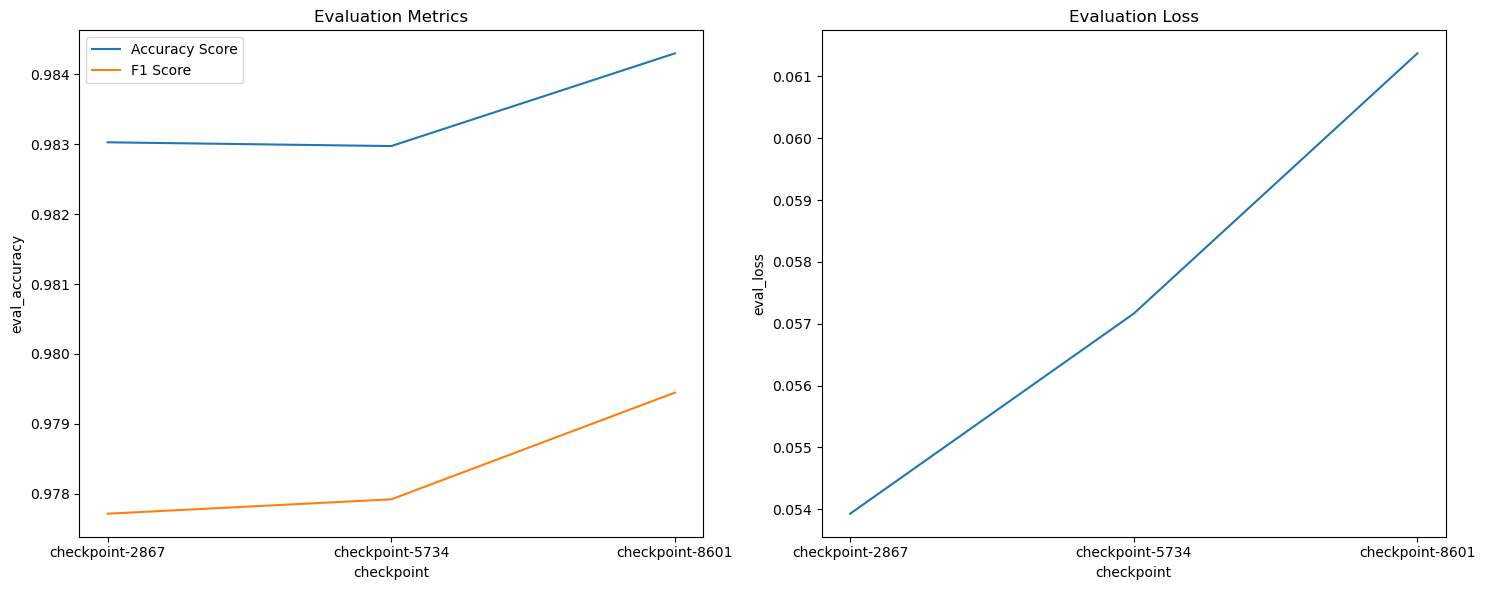

In [31]:
evalCheckpoints(
    "my-trainer",
    ["checkpoint-2867", "checkpoint-5734", "checkpoint-8601"],
    trainer=trainer,
)


In [35]:
pos = pipeline(
    "token-classification",
    model="my-trainer/checkpoint-8601",
    aggregation_strategy="simple",
    device=0,
)
pos


In [37]:
pos("Bill Gates was the CEO of Microsoft in Seattle, Washington DC.")

[{'entity_group': 'NOUN',
  'score': 0.9999341,
  'word': 'Bill Gates',
  'start': 0,
  'end': 10},
 {'entity_group': 'VERB',
  'score': 0.9999292,
  'word': 'was',
  'start': 11,
  'end': 14},
 {'entity_group': 'DET',
  'score': 0.99994147,
  'word': 'the',
  'start': 15,
  'end': 18},
 {'entity_group': 'NOUN',
  'score': 0.99991894,
  'word': 'CEO',
  'start': 19,
  'end': 22},
 {'entity_group': 'ADP',
  'score': 0.999943,
  'word': 'of',
  'start': 23,
  'end': 25},
 {'entity_group': 'NOUN',
  'score': 0.99994385,
  'word': 'Microsoft',
  'start': 26,
  'end': 35},
 {'entity_group': 'ADP',
  'score': 0.99993265,
  'word': 'in',
  'start': 36,
  'end': 38},
 {'entity_group': 'NOUN',
  'score': 0.9999522,
  'word': 'Seattle',
  'start': 39,
  'end': 46},
 {'entity_group': '.',
  'score': 0.9997726,
  'word': ',',
  'start': 46,
  'end': 47},
 {'entity_group': 'NOUN',
  'score': 0.9999351,
  'word': 'Washington DC',
  'start': 48,
  'end': 61},
 {'entity_group': '.',
  'score': 0.99993

In [95]:
def printSideBySide(list_1, list_2, separator="   "):
    """
    Prints two lists side by side. Columns must be aligned
    """

    # Get the width of the longest list item
    max_width = max(len(str(item)) for item in list_1 + list_2)

    # Print each item in the lists side by side, with the correct width
    for item_1, item_2 in zip(list_1, list_2):
        combined = "{:<{}}{}{:<{}}".format(item_1, max_width, separator, str(item_2), max_width)
        print(combined)

printSideBySide(["apple", "banana", "cherry"], ["red", "yellow", "blue"], separator="  ---->  ")


apple   ---->  red   
banana  ---->  yellow
cherry  ---->  blue  


In [96]:
def printPOS(pipeline_result):
    tokens, tags = [], []
    for token_result in pipeline_result:
        tokens.append(token_result['word'])
        tags.append(token_result['entity_group'])
    printSideBySide(tokens, tags, separator="  ---->  ")

In [97]:
printPOS(pos("Bill Gates was the CEO of Microsoft in Seattle, Washington DC."))

Bill Gates     ---->  NOUN         
was            ---->  VERB         
the            ---->  DET          
CEO            ---->  NOUN         
of             ---->  ADP          
Microsoft      ---->  NOUN         
in             ---->  ADP          
Seattle        ---->  NOUN         
,              ---->  .            
Washington DC  ---->  NOUN         
.              ---->  .            


/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [98]:
printPOS(pos("As long as you concentrate in your studies, you would be scoring good marks."))

As long           ---->  ADV             
as                ---->  ADP             
you               ---->  PRON            
concentrate       ---->  VERB            
in                ---->  ADP             
your              ---->  DET             
studies           ---->  NOUN            
,                 ---->  .               
you               ---->  PRON            
would be scoring  ---->  VERB            
good              ---->  ADJ             
marks             ---->  NOUN            
.                 ---->  .               
